## Limpieza de los datos

### Importación BBDD de MySQL

In [1]:
# instalacion de libreria para hacer la conexión con SQL Alchemy:
#pip install SQLAlchemy

In [2]:
# Conectar con MySQL usando SQLAlchemy
from sqlalchemy import create_engine
import pandas as pd

# Detalles de la conexión a la base de datos
host = '212.227.90.6'
database = 'Equip_10'
user = 'Equipo10'
password = 'E1q2u3i4p5o10'

# Crear la cadena de conexión para SQLAlchemy
engine = create_engine(f'mysql+pymysql://{user}:{password}@{host}/{database}')

try:
    # Conectar a la base de datos
    connection = engine.connect()
    print("Conectado al servidor MySQL usando SQLAlchemy")

    # Cargar la tabla tourist_accommodation usando pandas y SQLAlchemy
    df = pd.read_sql_table('Tourist_Accommodation', connection)
    print(f"Tabla 'Tourist_Accommodation' cargada en el DataFrame: df_tourist.")

except Exception as e:
    print(f"Error al conectar o leer la tabla: {e}")

finally:
    # Cerrar la conexión
    if 'connection' in locals() and connection:
        connection.close()
        print("Conexión cerrada")

Conectado al servidor MySQL usando SQLAlchemy
Tabla 'Tourist_Accommodation' cargada en el DataFrame: df_tourist.
Conexión cerrada


### Eliminación de casos duplicados en la FK 'apartment_id': 

Creación de un df que solo contenga los casos duplicados para poderlos examinar

In [3]:
# Suponiendo que tu DataFrame se llama 'df'
df_duplicados = df[df.duplicated(subset=['apartment_id'], keep=False)].copy()

Para la eliminación de los casos duplicados en 'apartment_id' hemos usado la variable 'insert_date' quedandonos con la fecha más moderna y eliminando el resto de registros repetidos.

In [4]:
# Transformar la variable temporal a datetime especificando el formato
df['insert_date'] = pd.to_datetime(df['insert_date'], format='%d/%m/%Y')

# Ordena el DataFrame por 'apartment_id' y luego por 'insert_date' de forma descendente
df_ordenado = df.sort_values(by=['apartment_id', 'insert_date'], ascending=[True, False])

# Elimina los duplicados de 'apartment_id', quedándonos con el primero (el más reciente por el ordenamiento)
df_sin_duplicados = df_ordenado.drop_duplicates(subset=['apartment_id'], keep='first').copy()

# Si quieres resetear el índice del DataFrame resultante
df_sin_duplicados = df_sin_duplicados.reset_index(drop=True)

print(f"Tamaño del DataFrame original: {len(df)}")
print(f"Tamaño del DataFrame sin duplicados: {len(df_sin_duplicados)}")

Tamaño del DataFrame original: 7001
Tamaño del DataFrame sin duplicados: 6733


### Eliminación de datos nulls y transformación de variables:

#### Transformación de variables temporales:

In [5]:
# Convertir las variables temporales a datetime:
df_sin_duplicados['first_review_date'] = pd.to_datetime(df_sin_duplicados['first_review_date'], format='%d/%m/%Y')
df_sin_duplicados['last_review_date'] = pd.to_datetime(df_sin_duplicados['last_review_date'], format='%d/%m/%Y')

#### Transformación las variables 'bathrooms','bedrooms' y 'beds'
- Para poder poner las variables con el formato adecuado primero se ha hacer un tratamiendo de los datos nulls.
- Se ha imputado el valor de la mediana de los nulls usando otras variables como referencia para crear grupos homogeneos.

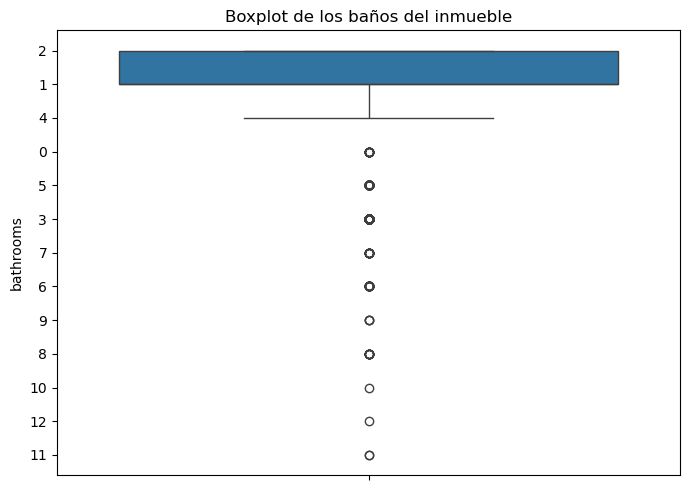

In [6]:
import matplotlib.pyplot as plt    
import seaborn as sns  

# Grafico boxplot
plt.figure(figsize=(7, 5))
sns.boxplot(data=df_sin_duplicados['bathrooms'])
plt.xticks(rotation=45)
plt.title('Boxplot de los baños del inmueble')
plt.tight_layout()
plt.show()

In [7]:
import numpy as np

# Primero, convierte la columna 'bathrooms' a numérico, los errores se convierten a NaN
df_sin_duplicados['bathrooms'] = pd.to_numeric(df_sin_duplicados['bathrooms'], errors='coerce')

# Calcula la mediana de 'bathrooms' por cada número de 'accommodates'
mediana_bathrooms_por_accommodates = df_sin_duplicados.groupby('accommodates')['bathrooms'].median()

# Imputa los valores nulos en 'bathrooms' usando la mediana correspondiente al número de 'accommodates'
def imputar_bathrooms(row):
    if pd.isnull(row['bathrooms']):
        return mediana_bathrooms_por_accommodates.get(row['accommodates'], df_sin_duplicados['bathrooms'].median()) # Si no hay mediana para ese 'accommodates', usa la mediana general
    return row['bathrooms']

df_sin_duplicados['bathrooms'] = df_sin_duplicados.apply(imputar_bathrooms, axis=1)

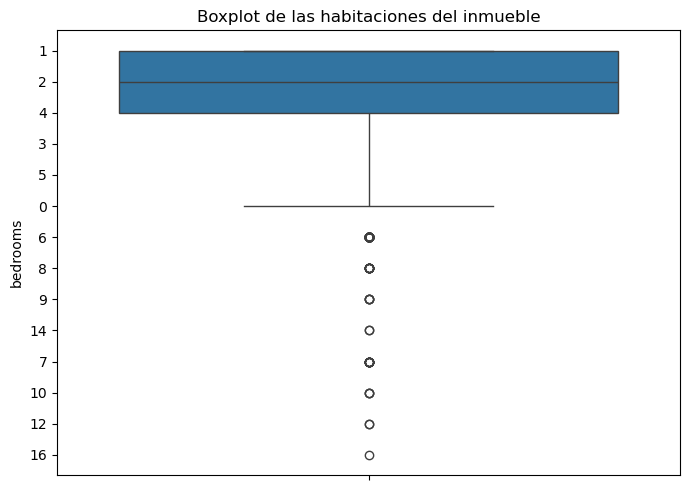

In [8]:
import matplotlib.pyplot as plt    
import seaborn as sns  

# Grafico boxplot
plt.figure(figsize=(7, 5))
sns.boxplot(data=df_sin_duplicados['bedrooms'])
plt.xticks(rotation=45)
plt.title('Boxplot de las habitaciones del inmueble')
plt.tight_layout()
plt.show()

In [9]:
# Convertir la columna 'bedrooms' a numérico
df_sin_duplicados['bedrooms'] = pd.to_numeric(df_sin_duplicados['bedrooms'], errors='coerce')

# Calcular la mediana de 'bedrooms' por cada número de 'accommodates'
mediana_bedrooms_por_accommodates = df_sin_duplicados.groupby('accommodates')['bedrooms'].median()

# Imputar los valores nulos en 'bedrooms'
def imputar_bedrooms(row):
    if pd.isnull(row['bedrooms']):
        return mediana_bedrooms_por_accommodates.get(row['accommodates'], df_sin_duplicados['bedrooms'].median())
    return row['bedrooms']

df_sin_duplicados['bedrooms'] = df_sin_duplicados.apply(imputar_bedrooms, axis=1)

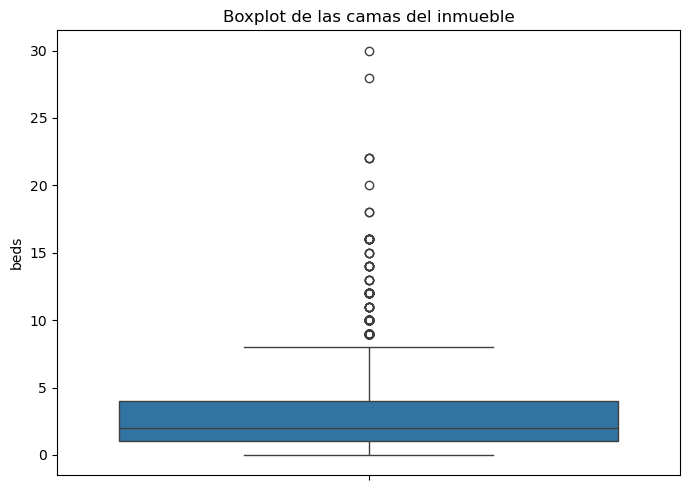

In [10]:
import matplotlib.pyplot as plt    
import seaborn as sns  

# Grafico boxplot
plt.figure(figsize=(7, 5))
sns.boxplot(data=df_sin_duplicados['beds'])
plt.xticks(rotation=45)
plt.title('Boxplot de las camas del inmueble')
plt.tight_layout()
plt.show()

In [11]:
# Calcular la mediana de 'beds' por cada número de 'accommodates'
mediana_bedrooms_por_accommodates = df_sin_duplicados.groupby('accommodates')['beds'].median()

# Imputar los valores nulos en 'beds'
def imputar_bedrooms(row):
    if pd.isnull(row['beds']):
        return mediana_bedrooms_por_accommodates.get(row['accommodates'], df_sin_duplicados['beds'].median())
    return row['beds']

df_sin_duplicados['beds'] = df_sin_duplicados.apply(imputar_bedrooms, axis=1)

Para poder imputar en la variable 'price' un valor a los datos nulls se han usado las variables 'room_type' y 'city' para calcular la mediana de cada grupo y a esos grupos donde falta price se le ha aplicado la mediana que corresponde

### Imputación de valores en la variable 'price'

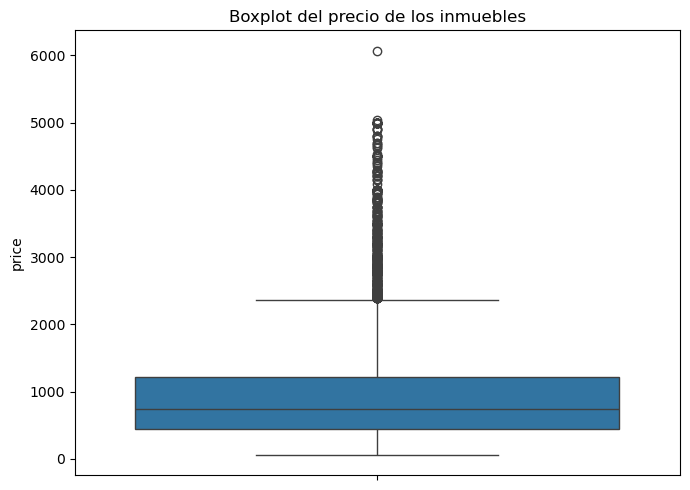

In [12]:
import matplotlib.pyplot as plt    
import seaborn as sns  

# Grafico boxplot
plt.figure(figsize=(7, 5))
sns.boxplot(data=df_sin_duplicados['price'])
plt.xticks(rotation=45)
plt.title('Boxplot del precio de los inmuebles')
plt.tight_layout()
plt.show()

In [13]:
# Calcular la mediana de 'price' por 'city' y 'room_type'
mediana_price_por_city_roomtype = df_sin_duplicados.groupby(['city', 'room_type'])['price'].median()

# Función para imputar los valores nulos en 'price'
def imputar_price(row):
    if pd.isnull(row['price']):
        try:
            return mediana_price_por_city_roomtype[(row['city'], row['room_type'])]
        except KeyError:
            return df_sin_duplicados['price'].median() # Si no existe la combinación, usa la mediana general
    return row['price']

# Aplicar la imputación
df_sin_duplicados['price'] = df_sin_duplicados.apply(imputar_price, axis=1)

### Imputación de valores nulls en las variables score
 - La variable 'review_scores_rating' está en una escala diferente a las otras variables, así que he igualado su escala a la de las otras variables. Solo ejecutar el código 1 vez si no la escala se hace más pequeña que el resto. 
 - Esta variable es la de puntuación global. 

In [14]:
# Dividir entre 10 para ponerla en la misma escala que las otras variables
df_sin_duplicados['review_scores_rating'] = df_sin_duplicados['review_scores_rating'] / 10

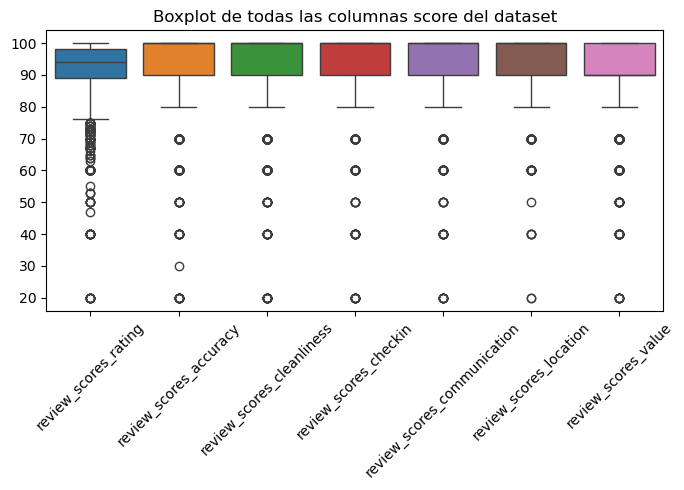

In [15]:
import matplotlib.pyplot as plt    
import seaborn as sns  

# Grafico boxplot
plt.figure(figsize=(7, 5))
sns.boxplot(data=df_sin_duplicados.iloc[:, 23:30])
plt.xticks(rotation=45)
plt.title('Boxplot de todas las columnas score del dataset')
plt.tight_layout()
plt.show()

In [16]:
columnas_a_imputar = ['review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
                       'review_scores_checkin', 'review_scores_communication', 'review_scores_location',
                       'review_scores_value', 'reviews_per_month']

for columna in columnas_a_imputar:
    # Imputar con la mediana del grupo
    df_sin_duplicados[columna] = df_sin_duplicados.groupby(['city', 'room_type'])[columna].transform(lambda x: x.fillna(x.median()))
    # Imputar los nulos restantes con la mediana de la columna completa
    mediana_global = df_sin_duplicados[columna].median()
    df_sin_duplicados[columna] = df_sin_duplicados[columna].fillna(mediana_global)

# Verificar la cantidad de nulos después de la imputación
print(df_sin_duplicados[columnas_a_imputar].isnull().sum())

review_scores_rating           0
review_scores_accuracy         0
review_scores_cleanliness      0
review_scores_checkin          0
review_scores_communication    0
review_scores_location         0
review_scores_value            0
reviews_per_month              0
dtype: int64


### Transformación variable has_availability todos los casos verdadero:

Hemos sustitudo 534 valores nulls imputandoles el valor True y hemos transformado el valor VERDADERO en True

In [17]:
# Transformar VERDADERO a True
df_sin_duplicados['has_availability'] = df_sin_duplicados['has_availability'].replace('VERDADERO', True)

# Imputacion a valores nulls por True
df_sin_duplicados['has_availability'].fillna(True, inplace=True)

C:\Users\giuia\AppData\Local\Temp\ipykernel_12536\1803279718.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_sin_duplicados['has_availability'].fillna(True, inplace=True)
C:\Users\giuia\AppData\Local\Temp\ipykernel_12536\1803279718.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_sin_duplicados['ha

### Datos nulls que siguen existiendo en el dataset:

In [18]:
# 1. Identificar filas con al menos un valor nulo:
df_sin_duplicados[df_sin_duplicados.isnull().any(axis=1)]

# 2. Obtener el número de valores nulos por columna y filtrar las que tienen al menos uno:
nulos_por_columna = df_sin_duplicados.isnull().sum()

# 3. Eliminar las variables que no tienen nulls de la visualizacion:
columnas_con_nulos = nulos_por_columna[nulos_por_columna > 0]
print("\nNúmero de valores nulos por columna (solo las que tienen nulos):")
print(columnas_con_nulos)


Número de valores nulos por columna (solo las que tienen nulos):
name                         3
description                 27
neighbourhood_district    2658
amenities_list              16
first_review_date         1203
last_review_date          1204
dtype: int64


### Transformación nombre dataset para crear archivo .csv y poder importar el documento en PowerBi

In [ ]:
# Cambio del nombre del dataset
#df_tourist = df_sin_duplicados

# Exportar el nuevo df como .csv
#nombre_archivo_csv = 'df_tourist.csv'
#df_tourist.to_csv(nombre_archivo_csv, index=False, encoding='utf-8')

# Mensaje sobre la operación realizada
#print(f"El DataFrame se ha guardado exitosamente en '{nombre_archivo_csv}'")

El DataFrame se ha guardado exitosamente en 'df_tourist.csv'


importamos librerias:

In [20]:
import warnings
warnings.filterwarnings("ignore")

from dotenv import load_dotenv
from scipy.stats import shapiro
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import pandas as pd


Inspeccionamos DF

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7001 entries, 0 to 7000
Data columns (total 35 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   apartment_id                 7001 non-null   int64         
 1   name                         6998 non-null   object        
 2   description                  6972 non-null   object        
 3   host_id                      7001 non-null   int64         
 4   neighbourhood_name           7001 non-null   object        
 5   neighbourhood_district       4241 non-null   object        
 6   room_type                    7001 non-null   object        
 7   accommodates                 7001 non-null   int64         
 8   bathrooms                    6969 non-null   object        
 9   bedrooms                     6972 non-null   object        
 10  beds                         6998 non-null   float64       
 11  amenities_list               6984 non-null 

In [22]:
df.describe().round(2)

,apartment_id,host_id,accommodates,beds,price,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,...,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,insert_date
count,7001.00,7.001000e+03,7001.00,6998.00,6870.00,7001.00,7001.00,7001.00,7001.00,7001.00,...,7001.00,5674.00,5665.00,5671.0,5660.00,5669.00,5659.00,5659.00,5747.00,7001
mean,15119780.99,6.218673e+07,4.35,3.01,1011.10,4.42,759.47,12.28,27.42,44.31,...,34.13,920.23,94.54,93.2,96.29,96.43,95.31,91.46,123.04,2019-04-19 14:26:57.711755520
min,11964.00,1.070400e+04,1.00,0.00,60.00,1.00,1.00,0.00,0.00,0.00,...,0.00,200.00,20.00,20.0,20.00,20.00,20.00,20.00,1.00,2017-01-04 00:00:00
25%,8749646.00,1.050015e+07,2.00,1.00,450.00,1.00,70.00,0.00,2.00,9.00,...,1.00,890.00,90.00,90.0,90.00,90.00,90.00,90.00,17.00,2018-08-14 00:00:00
50%,16737061.00,4.261380e+07,4.00,2.00,750.00,2.00,1125.00,10.00,26.00,46.00,...,9.00,940.00,100.00,100.0,100.00,100.00,100.00,90.00,57.00,2019-04-24 00:00:00
75%,21463214.00,1.062896e+08,6.00,4.00,1230.00,4.00,1125.00,24.00,50.00,76.00,...,40.00,980.00,100.00,100.0,100.00,100.00,100.00,100.00,177.00,2020-02-16 00:00:00
max,27245117.00,3.365242e+08,29.00,30.00,6071.00,365.00,1125.00,30.00,60.00,90.00,...,588.00,1000.00,100.00,100.0,100.00,100.00,100.00,100.00,1291.00,2021-02-27 00:00:00
std,7715577.75,5.747094e+07,2.62,2.33,845.98,10.67,497.96,11.51,22.41,33.02,...,59.94,85.35,9.06,9.7,7.96,7.61,7.30,9.31,153.16,NaN


### Variabilidad/distribución variable precio:

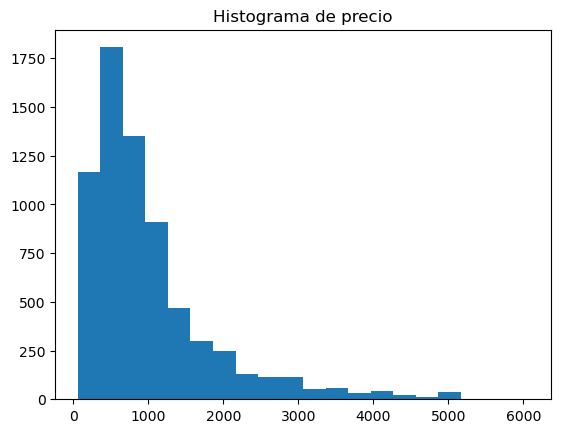

In [23]:
# Ajustamos la escala del eje Y para mostrar números completos ( sin notación cientifica por default)
plt.ticklabel_format(style='plain', axis='y')


plt.title('Histograma de precio')
plt.hist(df['price'], bins=20)
plt.show()

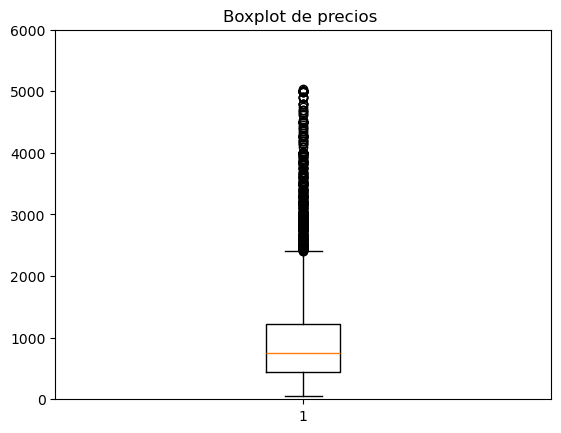

In [24]:
plt.boxplot(df['price'].dropna()) # quitamos los nan para evitar anomalias 
plt.ylim(0, 6000)  # Ajustamos los límites según los valores del dataset
plt.title('Boxplot de precios ')
plt.show()


### Limpieza de datos utilizando el IQR

Identificación/tratamiento de Outliers:

In [25]:
# Calcular el rango intercuartílico (IQR)
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1

# Definir los límites para considerar outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filtrar el DataFrame para mantener solo los valores dentro de los límites
df_filtered = df[(df['price'] >= lower_bound) & (df['price'] <= upper_bound)]

Volvemos a graficar la variable trás el tratamiento de los Outliers


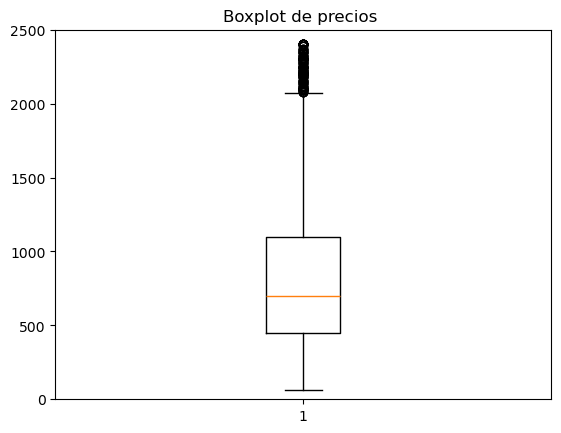

In [26]:
plt.boxplot(df_filtered['price'].dropna()) # quitamos los nan para evitar anomalias 
plt.ylim(0, 2500)  # Ajustamos los límites según los valores del dataset
plt.title('Boxplot de precios ')
plt.show()

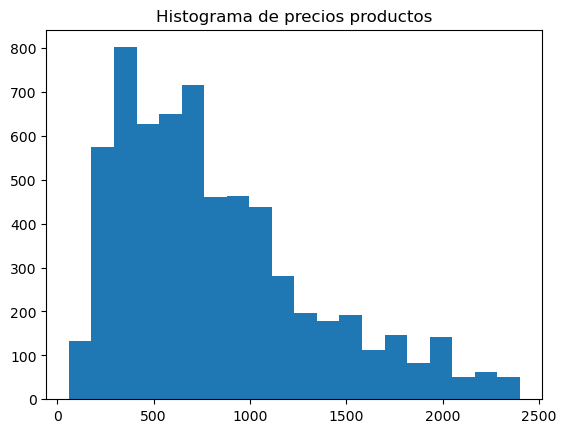

In [27]:
# Ajustamos la escala del eje Y para mostrar números completos ( sin notación cientifica por default)
plt.ticklabel_format(style='plain', axis='y')


# Histograma 
plt.title('Histograma de precios productos')
plt.hist(df_filtered['price'], bins=20)
plt.show()

In [28]:
df_filtered['price'].describe().round(2)

count    6361.00
mean      824.39
std       505.43
min        60.00
25%       450.00
50%       700.00
75%      1100.00
max      2400.00
Name: price, dtype: float64

In [29]:
df[['price']].var().round(2)

price    715674.34
dtype: float64

Verificamos dispersión de la variable price

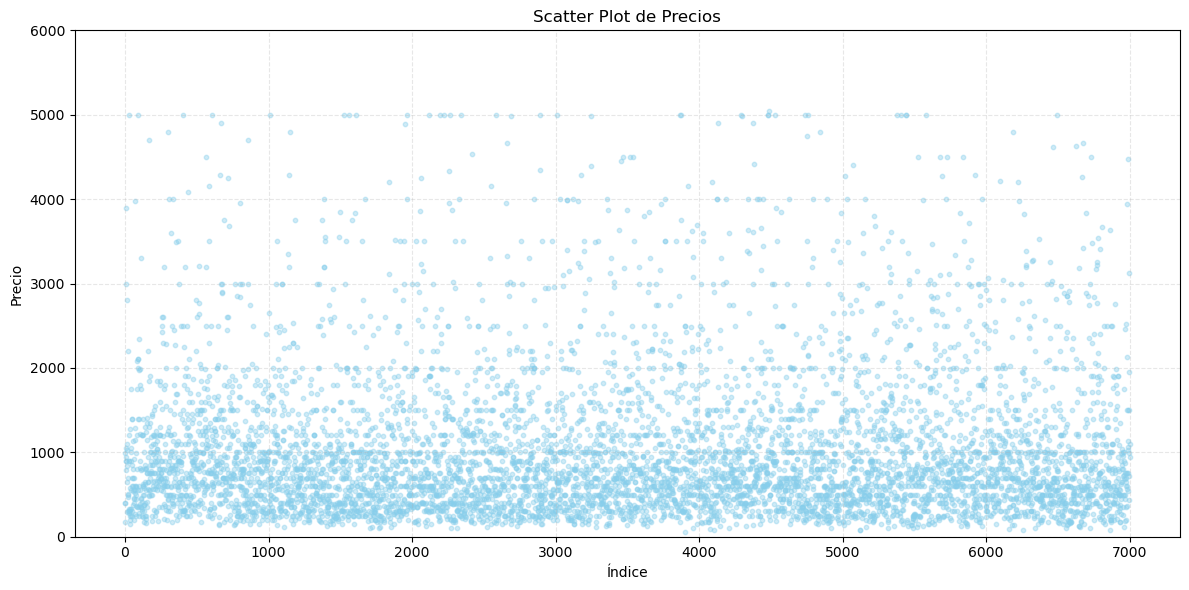

In [30]:
# Eliminamos los NaN
price_nonan = df['price'].dropna()

plt.figure(figsize=(12, 6))
plt.scatter(price_nonan.index, price_nonan, alpha=0.4, color='skyblue', s=10)
plt.ylim(0, 6000)
plt.title('Scatter Plot de Precios')
plt.xlabel('Índice')
plt.ylabel('Precio')
plt.grid(alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()


### Boxplot availability 

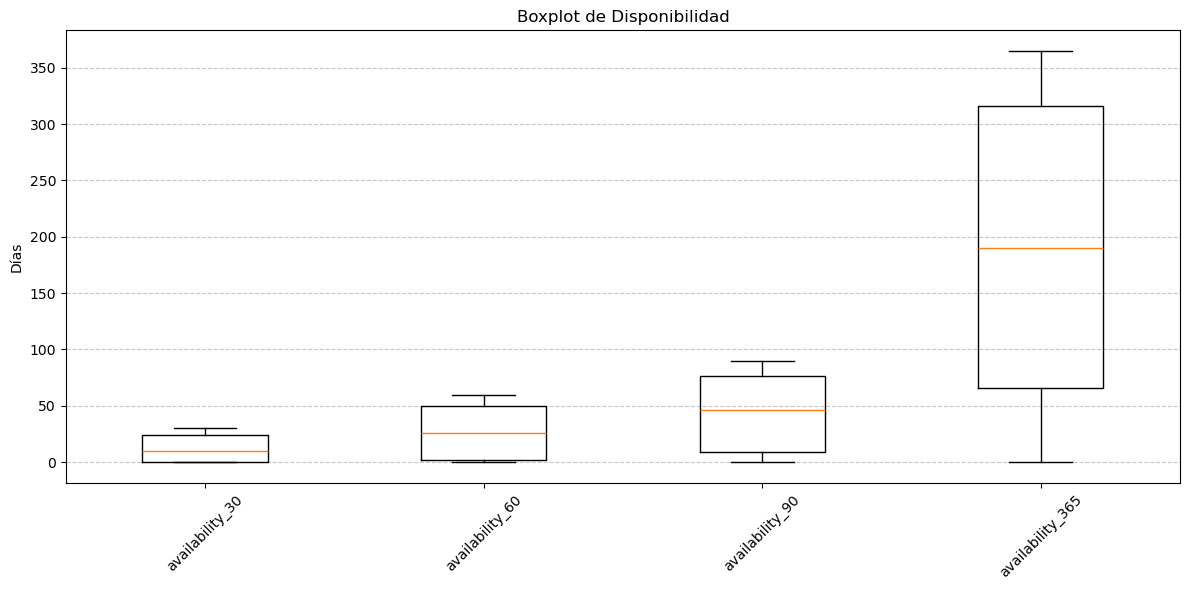

In [31]:
# Lista de variables
variables = ['availability_30', 'availability_60', 'availability_90', 'availability_365']

# Crear el boxplot
plt.figure(figsize=(12, 6))
plt.boxplot([df[var].dropna() for var in variables], labels=variables)
plt.title('Boxplot de Disponibilidad')
plt.ylabel('Días')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## EDA Operaciones

In [32]:
df_tourist

,apartment_id,name,description,host_id,neighbourhood_name,neighbourhood_district,room_type,accommodates,bathrooms,bedrooms,...,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,is_instant_bookable,reviews_per_month,country,city,insert_date
0,11964,A ROOM WITH A VIEW,Private bedroom in our attic apartment. Right ...,45553,Centro,None,Private room,2,2.0,1.0,...,100.0,100.0,100.0,100.0,100.0,FALSO,75.0,spain,malaga,2018-07-31
1,21853,Bright and airy room,We have a quiet and sunny room with a good vie...,83531,C�rmenes,Latina,Private room,1,1.0,1.0,...,90.0,100.0,100.0,80.0,90.0,FALSO,52.0,spain,madrid,2020-01-10
2,32347,Explore Cultural Sights from a Family-Friendly...,Open French doors and step onto a plant-filled...,139939,San Vicente,Casco Antiguo,Entire home/apt,4,1.0,2.0,...,100.0,100.0,100.0,100.0,100.0,VERDADERO,142.0,spain,sevilla,2019-07-29
3,35379,Double 02 CasanovaRooms Barcelona,Room at a my apartment. Kitchen and 2 bathroom...,152232,l'Antiga Esquerra de l'Eixample,Eixample,Private room,2,2.0,1.0,...,90.0,100.0,100.0,100.0,90.0,VERDADERO,306.0,spain,barcelona,2020-01-10
4,35801,Can Torras Farmhouse Studio Suite,Lay in bed & watch sunlight change the mood of...,153805,Quart,None,Private room,5,1.0,2.0,...,100.0,100.0,100.0,100.0,100.0,FALSO,39.0,spain,girona,2019-02-19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6728,27237828,Studio at Finca Els Olivers,"Independent guest house, forming part of an ex...",1323233,B�scara,None,Entire home/apt,2,1.0,1.0,...,100.0,100.0,100.0,100.0,100.0,FALSO,10.0,spain,girona,2018-08-30
6729,27241318,ES MOLI D'EN SION - Villa with private pool in...,Enjoy the peace of the countryside in this bea...,80839530,Sa Pobla,None,Entire home/apt,10,4.0,5.0,...,100.0,100.0,100.0,100.0,100.0,VERDADERO,7.0,spain,mallorca,2020-04-23
6730,27244243,101.108_New building apartment with two double...,Apartment in Cadaqu�s center. 1rst �floor. Ele...,151496825,Cadaqu�s,None,Entire home/apt,4,1.0,2.0,...,100.0,100.0,100.0,100.0,90.0,VERDADERO,24.0,spain,girona,2018-08-30
6731,27244794,101.38_Apartment with one doble bedroom and te...,101.38.- Apartment placed Sa T�rtora � Sant An...,151496825,Cadaqu�s,None,Entire home/apt,2,1.0,1.0,...,100.0,100.0,100.0,100.0,100.0,VERDADERO,6.0,spain,girona,2019-12-31


Crear dataset Operaciones

In [33]:
df_op = df_tourist[['apartment_id','host_id','country','city','neighbourhood_name','neighbourhood_district','accommodates','room_type','description','amenities_list','beds','bedrooms','bathrooms','minimum_nights','maximum_nights','is_instant_bookable','availability_30','availability_60','availability_90','availability_365','price','insert_date']]

df_op

,apartment_id,host_id,country,city,neighbourhood_name,neighbourhood_district,accommodates,room_type,description,amenities_list,...,bathrooms,minimum_nights,maximum_nights,is_instant_bookable,availability_30,availability_60,availability_90,availability_365,price,insert_date
0,11964,45553,spain,malaga,Centro,None,2,Private room,Private bedroom in our attic apartment. Right ...,"TV,Internet,Wifi,Air conditioning,Elevator,Buz...",...,2.0,3,365,FALSO,7,20,40,130,400.0,2018-07-31
1,21853,83531,spain,madrid,C�rmenes,Latina,1,Private room,We have a quiet and sunny room with a good vie...,"TV,Internet,Wifi,Air conditioning,Kitchen,Free...",...,1.0,4,40,FALSO,0,0,0,162,170.0,2020-01-10
2,32347,139939,spain,sevilla,San Vicente,Casco Antiguo,4,Entire home/apt,Open French doors and step onto a plant-filled...,"TV,Internet,Wifi,Air conditioning,Wheelchair a...",...,1.0,2,120,VERDADERO,26,31,31,270,990.0,2019-07-29
3,35379,152232,spain,barcelona,l'Antiga Esquerra de l'Eixample,Eixample,2,Private room,Room at a my apartment. Kitchen and 2 bathroom...,"TV,Internet,Wifi,Kitchen,Breakfast,Elevator,Bu...",...,2.0,2,730,VERDADERO,9,23,49,300,400.0,2020-01-10
4,35801,153805,spain,girona,Quart,None,5,Private room,Lay in bed & watch sunlight change the mood of...,"Wifi,Pool,Free parking on premises,Breakfast,P...",...,1.0,1,180,FALSO,0,19,49,312,900.0,2019-02-19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6728,27237828,1323233,spain,girona,B�scara,None,2,Entire home/apt,"Independent guest house, forming part of an ex...","TV,Cable TV,Internet,Wifi,Air conditioning,Poo...",...,1.0,2,1124,FALSO,22,47,77,78,1500.0,2018-08-30
6729,27241318,80839530,spain,mallorca,Sa Pobla,None,10,Entire home/apt,Enjoy the peace of the countryside in this bea...,"TV,Cable TV,Internet,Wifi,Air conditioning,Poo...",...,4.0,7,1125,VERDADERO,26,37,37,243,3130.0,2020-04-23
6730,27244243,151496825,spain,girona,Cadaqu�s,None,4,Entire home/apt,Apartment in Cadaqu�s center. 1rst �floor. Ele...,"TV,Internet,Wifi,Air conditioning,Kitchen,Elev...",...,1.0,1,1125,VERDADERO,24,40,40,40,990.0,2018-08-30
6731,27244794,151496825,spain,girona,Cadaqu�s,None,2,Entire home/apt,101.38.- Apartment placed Sa T�rtora � Sant An...,"TV,Kitchen,Buzzer/wireless intercom,Family/kid...",...,1.0,1,1125,VERDADERO,0,0,0,0,720.0,2019-12-31


Crear nuevas columnas ( mes, año, trimestre)

In [ ]:
# Create new columns
df_op['month'] = df_op['insert_date'].dt.month  # Numeric month (1-12)
df_op['month_name'] = df_op['insert_date'].dt.month_name()  # Name of the month
df_op['quarter'] = df_op['insert_date'].dt.quarter  # Quarter (1-4)
df_op['year'] = df_op['insert_date'].dt.year  # Year


In [ ]:
df_op

,apartment_id,host_id,country,city,neighbourhood_name,neighbourhood_district,accommodates,room_type,description,amenities_list,...,availability_30,availability_60,availability_90,availability_365,price,insert_date,month,month_name,quarter,year
0,11964,45553,spain,malaga,Centro,None,2,Private room,Private bedroom in our attic apartment. Right ...,"TV,Internet,Wifi,Air conditioning,Elevator,Buz...",...,7,20,40,130,400.0,2018-07-31,7,July,3,2018
1,21853,83531,spain,madrid,C�rmenes,Latina,1,Private room,We have a quiet and sunny room with a good vie...,"TV,Internet,Wifi,Air conditioning,Kitchen,Free...",...,0,0,0,162,170.0,2020-01-10,1,January,1,2020
2,32347,139939,spain,sevilla,San Vicente,Casco Antiguo,4,Entire home/apt,Open French doors and step onto a plant-filled...,"TV,Internet,Wifi,Air conditioning,Wheelchair a...",...,26,31,31,270,990.0,2019-07-29,7,July,3,2019
3,35379,152232,spain,barcelona,l'Antiga Esquerra de l'Eixample,Eixample,2,Private room,Room at a my apartment. Kitchen and 2 bathroom...,"TV,Internet,Wifi,Kitchen,Breakfast,Elevator,Bu...",...,9,23,49,300,400.0,2020-01-10,1,January,1,2020
4,35801,153805,spain,girona,Quart,None,5,Private room,Lay in bed & watch sunlight change the mood of...,"Wifi,Pool,Free parking on premises,Breakfast,P...",...,0,19,49,312,900.0,2019-02-19,2,February,1,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6728,27237828,1323233,spain,girona,B�scara,None,2,Entire home/apt,"Independent guest house, forming part of an ex...","TV,Cable TV,Internet,Wifi,Air conditioning,Poo...",...,22,47,77,78,1500.0,2018-08-30,8,August,3,2018
6729,27241318,80839530,spain,mallorca,Sa Pobla,None,10,Entire home/apt,Enjoy the peace of the countryside in this bea...,"TV,Cable TV,Internet,Wifi,Air conditioning,Poo...",...,26,37,37,243,3130.0,2020-04-23,4,April,2,2020
6730,27244243,151496825,spain,girona,Cadaqu�s,None,4,Entire home/apt,Apartment in Cadaqu�s center. 1rst �floor. Ele...,"TV,Internet,Wifi,Air conditioning,Kitchen,Elev...",...,24,40,40,40,990.0,2018-08-30,8,August,3,2018
6731,27244794,151496825,spain,girona,Cadaqu�s,None,2,Entire home/apt,101.38.- Apartment placed Sa T�rtora � Sant An...,"TV,Kitchen,Buzzer/wireless intercom,Family/kid...",...,0,0,0,0,720.0,2019-12-31,12,December,4,2019


In [ ]:
df_op.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6733 entries, 0 to 6732
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   apartment_id            6733 non-null   int64         
 1   host_id                 6733 non-null   int64         
 2   country                 6733 non-null   object        
 3   city                    6733 non-null   object        
 4   neighbourhood_name      6733 non-null   object        
 5   neighbourhood_district  4075 non-null   object        
 6   accommodates            6733 non-null   int64         
 7   room_type               6733 non-null   object        
 8   description             6706 non-null   object        
 9   amenities_list          6717 non-null   object        
 10  beds                    6733 non-null   float64       
 11  bedrooms                6733 non-null   float64       
 12  bathrooms               6733 non-null   float64 

In [ ]:
df_op.describe().round(2)

,apartment_id,host_id,accommodates,beds,bedrooms,bathrooms,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,price,insert_date,month,quarter,year
count,6733.00,6.733000e+03,6733.00,6733.00,6733.00,6733.00,6733.00,6733.00,6733.00,6733.00,6733.00,6733.00,6733.00,6733,6733.00,6733.00,6733.00
mean,15127170.44,6.242871e+07,4.35,3.01,1.96,1.60,4.42,756.98,12.29,27.42,44.30,187.39,1012.03,2019-04-23 18:55:39.610872064,6.46,2.50,2018.81
min,11964.00,1.070400e+04,1.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,60.00,2017-01-04 00:00:00,1.00,1.00,2017.00
25%,8699662.00,1.054730e+07,2.00,1.00,1.00,1.00,1.00,62.00,0.00,2.00,9.00,65.00,460.00,2018-08-14 00:00:00,3.00,1.00,2018.00
50%,16772799.00,4.302790e+07,4.00,2.00,2.00,1.00,2.00,1125.00,10.00,26.00,46.00,188.00,750.00,2019-04-27 00:00:00,6.00,2.00,2019.00
75%,21480621.00,1.066918e+08,6.00,4.00,3.00,2.00,4.00,1125.00,24.00,50.00,76.00,316.00,1250.00,2020-02-18 00:00:00,10.00,4.00,2020.00
max,27245117.00,3.365242e+08,29.00,30.00,16.00,12.00,365.00,1125.00,30.00,60.00,90.00,365.00,6071.00,2021-02-27 00:00:00,12.00,4.00,2021.00
std,7729288.27,5.754856e+07,2.63,2.34,1.30,0.99,10.78,498.75,11.54,22.48,33.11,130.16,838.64,NaN,3.50,1.12,1.05


In [ ]:
df_op['accommodates'].var()

6.9025542995147875

In [ ]:
df_op['accommodates'].mode()

0    2
Name: accommodates, dtype: int64

In [ ]:
df_op['minimum_nights'].mode()

0    1
Name: minimum_nights, dtype: int64

In [ ]:
df_op['maximum_nights'].mode()

0    1125
Name: maximum_nights, dtype: int64

Boxplot e Histogramas de la variable accommodates

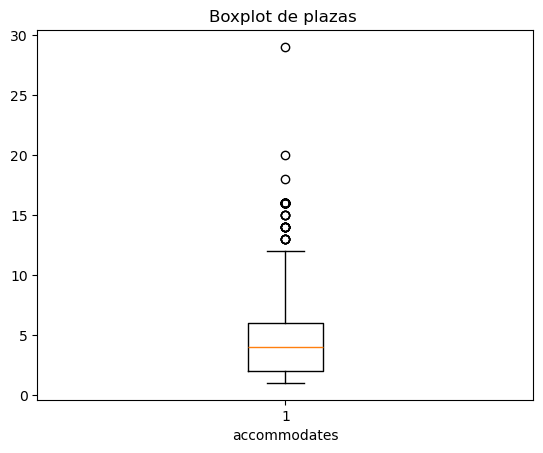

In [ ]:
plt.boxplot(df_op['accommodates'])
plt.title('Boxplot de plazas ')
plt.xlabel('accommodates')
plt.show()

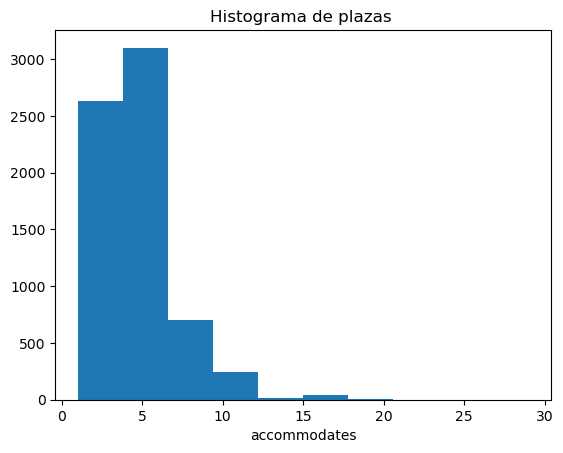

In [ ]:
plt.hist(df_op['accommodates'])
plt.title('Histograma de plazas ')
plt.xlabel('accommodates')
plt.show()

Boxplots de numero de Camas, Dormitorios y Baños

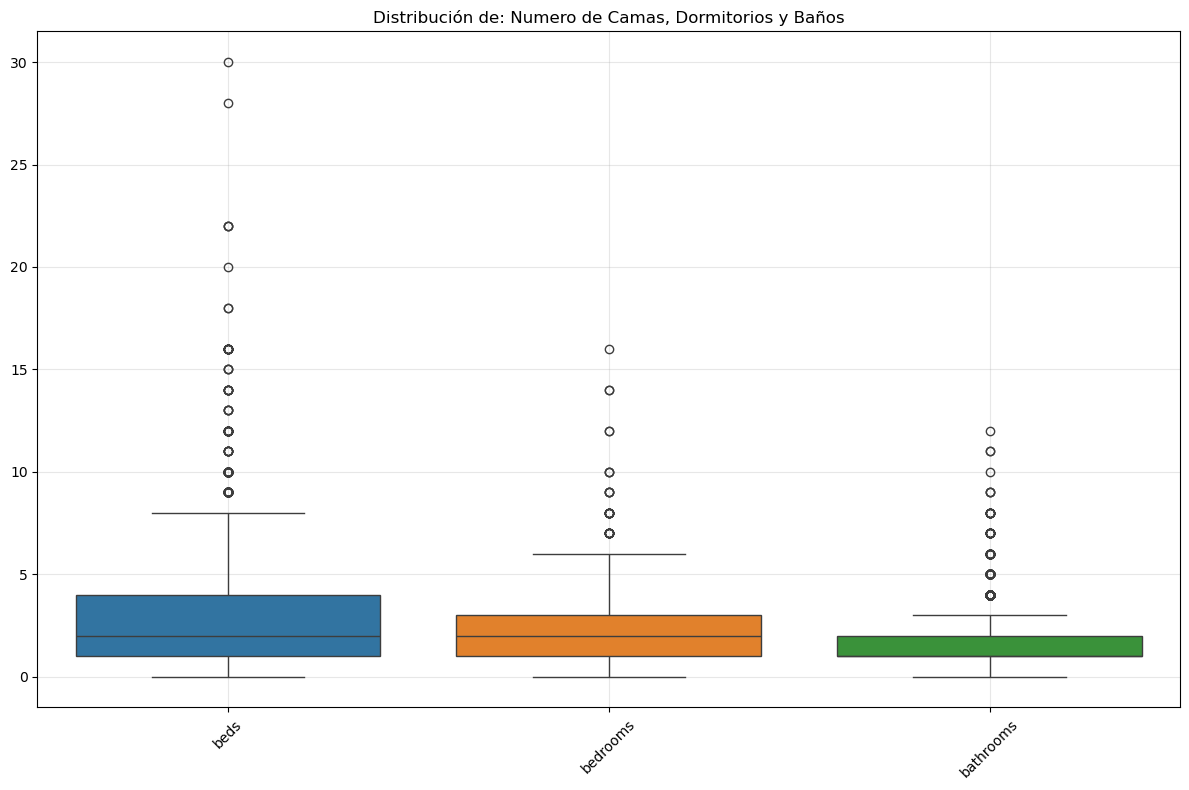

In [ ]:


plt.figure(figsize=(12, 8))
sns.boxplot(data=df_op[[ 'beds', 'bedrooms', 'bathrooms']])
plt.title('Distribución de: Numero de Camas, Dormitorios y Baños')
plt.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Histogramas de Camas, Dormitorios y Baños

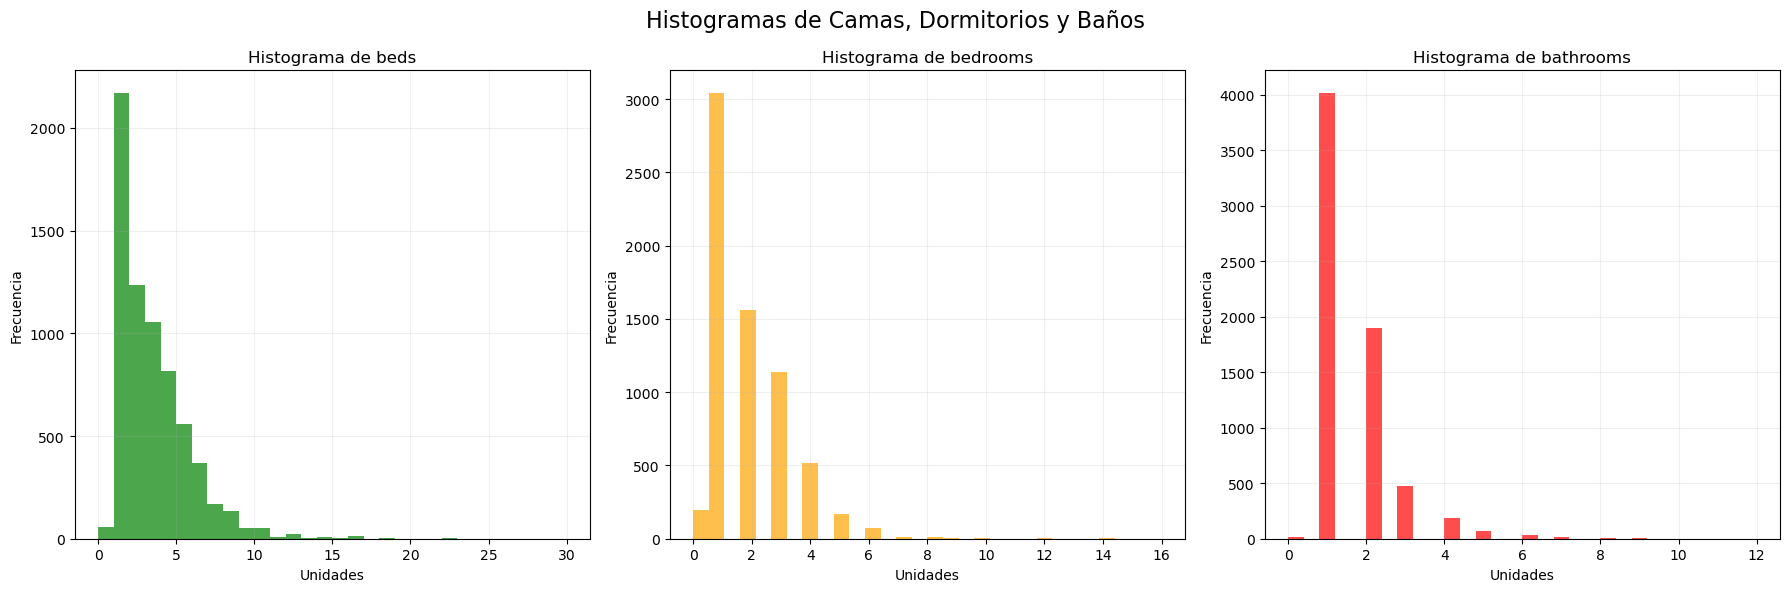

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

variables = ['beds', 'bedrooms', 'bathrooms']
colors = ['green', 'orange', 'red']

for i, var in enumerate(variables):
    ax = axes[i]
    ax.hist(df_op[var], bins=30, color=colors[i], alpha=0.7)
    ax.set_title(f'Histograma de {var}')
    ax.grid(alpha=0.2)
    ax.set_xlabel('Unidades')
    ax.set_ylabel('Frecuencia')

plt.suptitle('Histogramas de Camas, Dormitorios y Baños', fontsize=16)
plt.tight_layout()
plt.show()


Averiguar distribución normal de las variables

In [ ]:
from scipy.stats import shapiro

# Seleccionar las columnas de interés
columns_to_test = ['accommodates', 'beds', 'bedrooms', 'bathrooms']

# Iterar sobre las columnas y realizar el Shapiro-Wilk Test
for col in columns_to_test:
    stat, p_value = shapiro(df_op[col])
    print(f"{col}: W-statistic = {stat:.4f}, p-value = {p_value:.4f}")

    if p_value < 0.05:
        print(f"La variable {col} no sigue una distribución normal (rechazamos H0)")
    else:
        print(f"La variable {col} sigue una distribución normal (no rechazamos H0)")
    print('-' * 50)


accommodates: W-statistic = 0.8877, p-value = 0.0000
La variable accommodates no sigue una distribución normal (rechazamos H0)
--------------------------------------------------
beds: W-statistic = 0.8044, p-value = 0.0000
La variable beds no sigue una distribución normal (rechazamos H0)
--------------------------------------------------
bedrooms: W-statistic = 0.8110, p-value = 0.0000
La variable bedrooms no sigue una distribución normal (rechazamos H0)
--------------------------------------------------
bathrooms: W-statistic = 0.6440, p-value = 0.0000
La variable bathrooms no sigue una distribución normal (rechazamos H0)
--------------------------------------------------


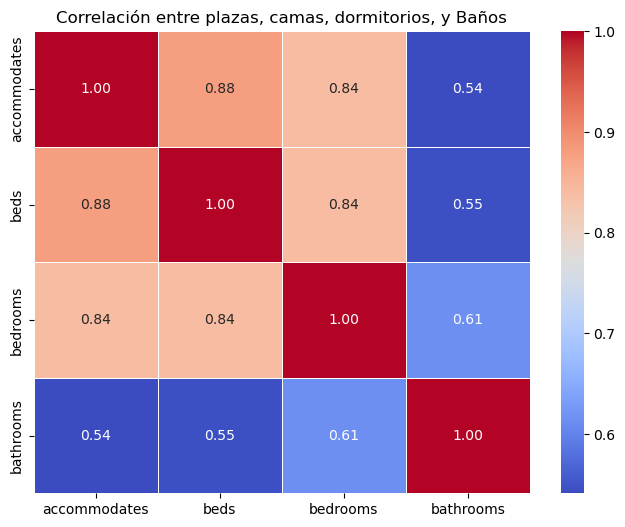

In [ ]:


# Selecciona las columnas numéricas de interés
correlation_columns = ['accommodates', 'beds', 'bedrooms', 'bathrooms']

# Calcula la matriz de correlación
corr_matrix = df_op[correlation_columns].corr(method='spearman')

# Graficar el heatmap de correlación
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlación entre plazas, camas, dormitorios, y Baños')
plt.show()


Distribución de la variable room_type

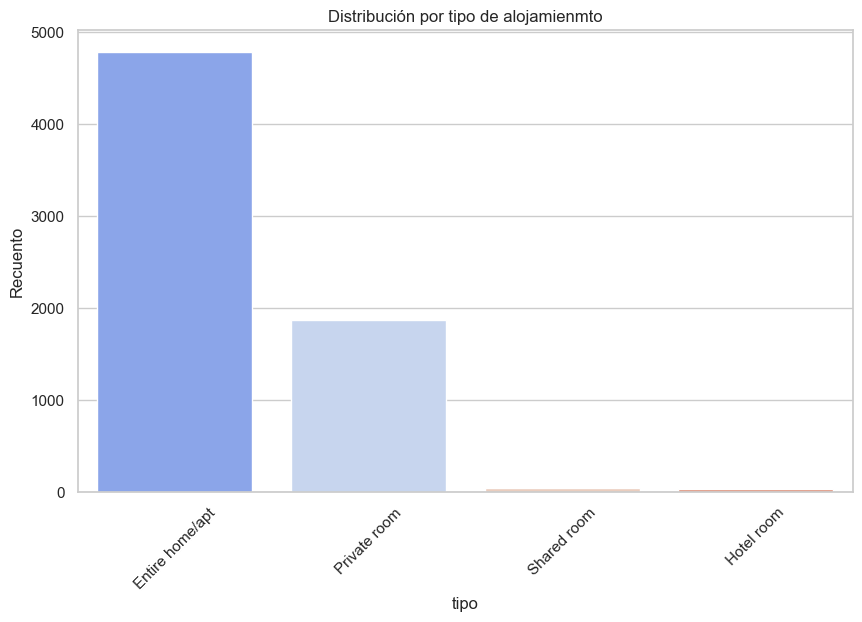

In [ ]:


# Configuración del estilo de Seaborn
sns.set(style="whitegrid")

# Distribución de room_type
plt.figure(figsize=(10, 6))
sns.countplot(data=df_op, x='room_type', palette='coolwarm', order=df_op['room_type'].value_counts().index)
plt.title('Distribución por tipo de alojamienmto')
plt.xticks(rotation=45)
plt.xlabel('tipo')
plt.ylabel('Recuento')
plt.show()


Comparación de room_type con Variables Numéricas (Boxplot):
vemos cómo se distribuyen accommodates, beds y bathrooms por tipo de Alojamiento:

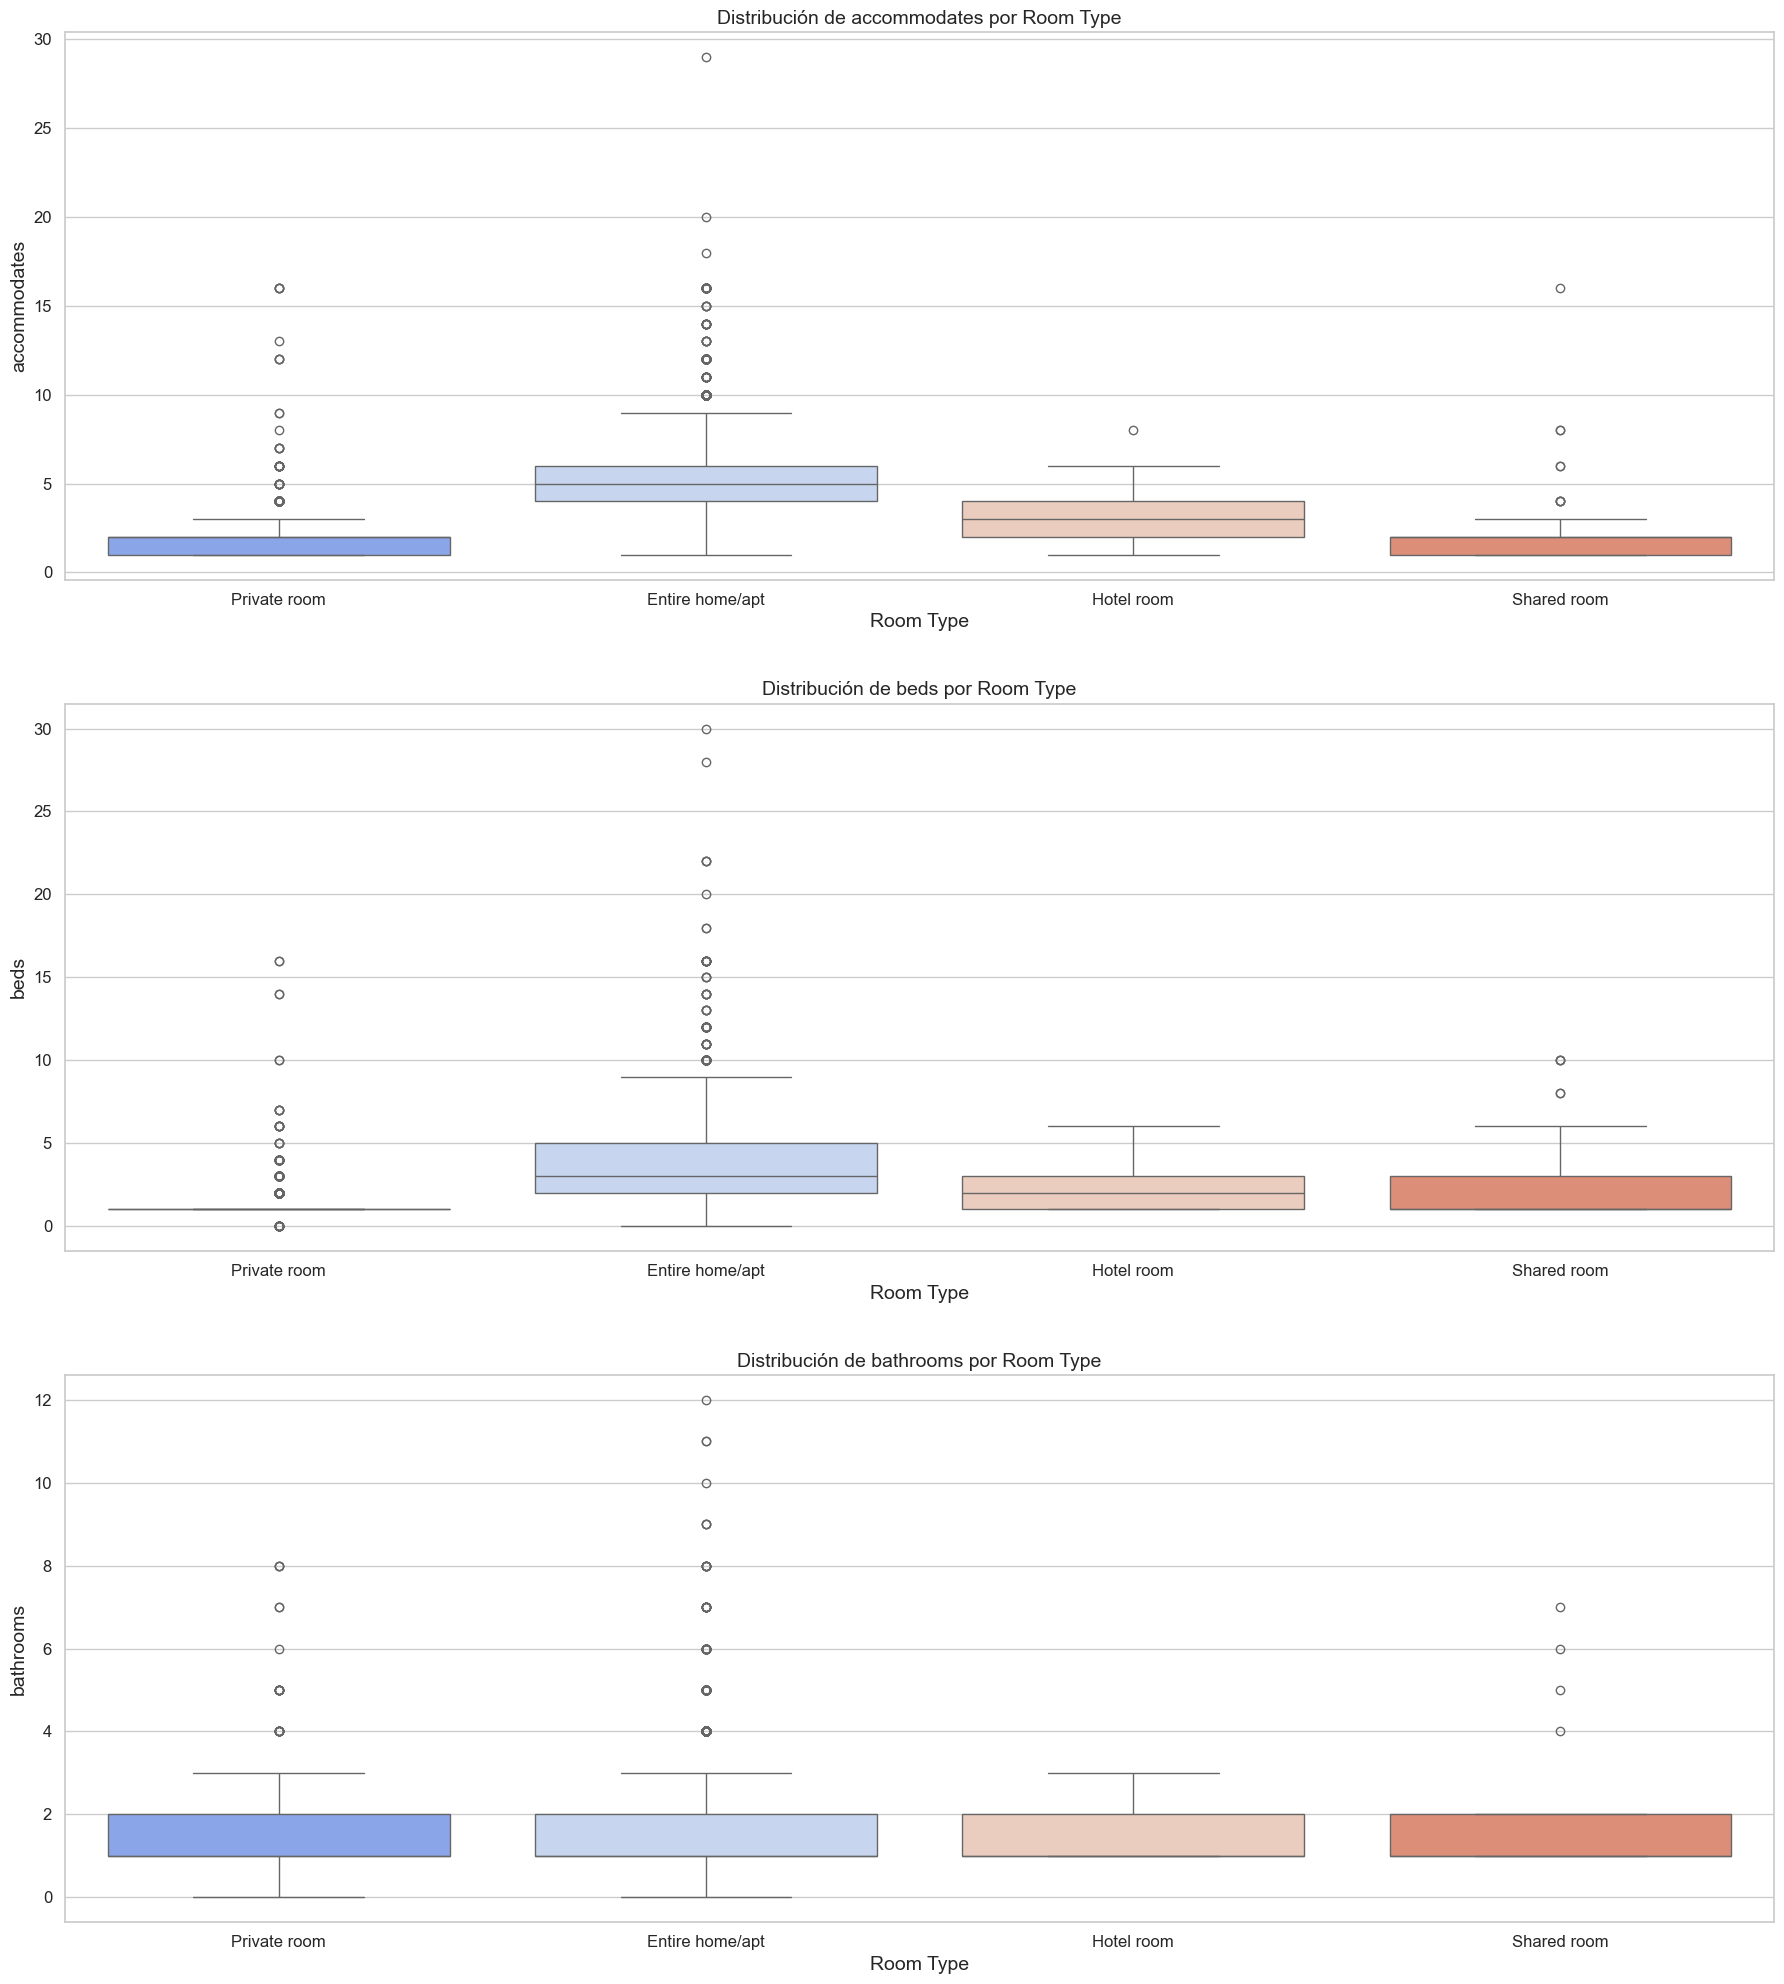

In [ ]:
# Variables numéricas a comparar
num_vars = ['accommodates', 'beds', 'bathrooms']

# Ajuste del tamaño del gráfico 
plt.figure(figsize=(18, 20))  

for i, var in enumerate(num_vars, 1):
    plt.subplot(len(num_vars), 1, i)
    sns.boxplot(data=df_op, x='room_type', y=var, palette='coolwarm')
    plt.title(f'Distribución de {var} por Room Type', fontsize=14)
    plt.xticks(rotation=0, fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlabel('Room Type', fontsize=14)
    plt.ylabel(var, fontsize=14)
    plt.tight_layout(h_pad=3)  

plt.show()


Conteo de tipo de alojamiento por ciudad

In [ ]:


# Agrupar por 'city' y 'room_type' para obtener el conteo
room_city_count = df_op.groupby(['city', 'room_type']).size().reset_index(name='count')

# Crear el gráfico de barras apiladas
fig = px.bar(room_city_count, x='city', y='count', color='room_type', 
             title='Recuento de tipo de alojamiento por Ciudad', 
             labels={'city': 'City'}, 
             height=600, barmode='stack')

# Configurar el gráfico
fig.update_layout(xaxis_title='Ciudad', yaxis_title='Conteo', xaxis_tickangle=45)

fig.show()


Numero de Alojamientos registrados por Día

In [ ]:
# Contar alojamientos por día
alojamientos_por_dia = df_op['insert_date'].dt.date.value_counts().sort_index()

# Crear DataFrame para Plotly
df_dia = alojamientos_por_dia.reset_index()
df_dia.columns = ['Fecha', 'Cantidad']

fig = px.line(df_dia, x='Fecha', y='Cantidad', 
              title='Numero de Alojamientos registrados por Día',
              markers=True,
              template='plotly_dark')
fig.update_layout(xaxis_title='Fecha', yaxis_title='Cantidad de Alojamientos')
fig.show()

Media de disponibilidad global ( 30/60/90/365)

In [166]:

media_disp_glob = df_op[['availability_30', 'availability_60', 'availability_90', 'availability_365']].mean().reset_index(name= 'Media_dispo_global_dias').round(2)

media_disp_glob 


,index,Media_dispo_global_dias
0,availability_30,12.29
1,availability_60,27.42
2,availability_90,44.30
3,availability_365,187.39


Media de disponibilidad por ciudad ( 30/60/90/365)

In [ ]:
media_disp_ciudad = df_op.groupby('city')[['availability_30', 'availability_60', 'availability_90', 'availability_365']].agg('mean').round(2).reset_index()

media_disp_ciudad 

,city,availability_30,availability_60,availability_90,availability_365
0,barcelona,11.11,25.63,42.50,182.09
1,girona,14.59,31.27,48.35,195.07
2,madrid,10.41,24.12,39.95,163.56
3,malaga,12.14,28.43,47.13,202.65
4,mallorca,13.41,28.70,45.17,210.92
5,menorca,14.99,30.88,47.54,199.49
6,sevilla,14.06,30.92,50.05,199.75
7,valencia,13.59,29.73,47.72,183.75


In [186]:

# Crear el gráfico de barras agrupadas
fig = px.bar(
    media_disp_ciudad,
    x='city',
    y=['availability_30', 'availability_60', 'availability_90', 'availability_365'],
    title='Media de Disponibilidad por Ciudad',
    labels={'value': 'Media de Disponibilidad', 'city': 'Ciudad'},
    height=600
)

# barras agrupadas
fig.update_layout(barmode='group')

fig.show()


### Tasa de ocupación Mensual

Crear columnas ocupación 30/60/90/365

In [ ]:

for period in [30, 60, 90, 365]:
    column_name = f'occupied_days_{period}'
    availability_col = f'availability_{period}'
    
    if availability_col in df_op.columns:
        df_op[column_name] = period - df_op[availability_col]

df_op


,apartment_id,host_id,country,city,neighbourhood_name,neighbourhood_district,accommodates,room_type,description,amenities_list,...,price,insert_date,month,month_name,quarter,year,occupied_days_30,occupied_days_60,occupied_days_90,occupied_days_365
0,11964,45553,spain,malaga,Centro,None,2,Private room,Private bedroom in our attic apartment. Right ...,"TV,Internet,Wifi,Air conditioning,Elevator,Buz...",...,400.0,2018-07-31,7,July,3,2018,23,40,50,235
1,21853,83531,spain,madrid,C�rmenes,Latina,1,Private room,We have a quiet and sunny room with a good vie...,"TV,Internet,Wifi,Air conditioning,Kitchen,Free...",...,170.0,2020-01-10,1,January,1,2020,30,60,90,203
2,32347,139939,spain,sevilla,San Vicente,Casco Antiguo,4,Entire home/apt,Open French doors and step onto a plant-filled...,"TV,Internet,Wifi,Air conditioning,Wheelchair a...",...,990.0,2019-07-29,7,July,3,2019,4,29,59,95
3,35379,152232,spain,barcelona,l'Antiga Esquerra de l'Eixample,Eixample,2,Private room,Room at a my apartment. Kitchen and 2 bathroom...,"TV,Internet,Wifi,Kitchen,Breakfast,Elevator,Bu...",...,400.0,2020-01-10,1,January,1,2020,21,37,41,65
4,35801,153805,spain,girona,Quart,None,5,Private room,Lay in bed & watch sunlight change the mood of...,"Wifi,Pool,Free parking on premises,Breakfast,P...",...,900.0,2019-02-19,2,February,1,2019,30,41,41,53
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6728,27237828,1323233,spain,girona,B�scara,None,2,Entire home/apt,"Independent guest house, forming part of an ex...","TV,Cable TV,Internet,Wifi,Air conditioning,Poo...",...,1500.0,2018-08-30,8,August,3,2018,8,13,13,287
6729,27241318,80839530,spain,mallorca,Sa Pobla,None,10,Entire home/apt,Enjoy the peace of the countryside in this bea...,"TV,Cable TV,Internet,Wifi,Air conditioning,Poo...",...,3130.0,2020-04-23,4,April,2,2020,4,23,53,122
6730,27244243,151496825,spain,girona,Cadaqu�s,None,4,Entire home/apt,Apartment in Cadaqu�s center. 1rst �floor. Ele...,"TV,Internet,Wifi,Air conditioning,Kitchen,Elev...",...,990.0,2018-08-30,8,August,3,2018,6,20,50,325
6731,27244794,151496825,spain,girona,Cadaqu�s,None,2,Entire home/apt,101.38.- Apartment placed Sa T�rtora � Sant An...,"TV,Kitchen,Buzzer/wireless intercom,Family/kid...",...,720.0,2019-12-31,12,December,4,2019,30,60,90,365


Crear columna tasa de ocupación 

In [ ]:
# Crear columnas de tasa de ocupación para 30, 60, 90, 365 días
for period in [30, 60, 90, 365]:
    availability_col = f'availability_{period}'
    occupied_col = f'occupied_days_{period}'
    occupancy_rate_col = f'occupancy_rate_%_{period}'
    
    if availability_col in df_op.columns:
        # Calcular la tasa de ocupación en porcentaje
        df_op[occupancy_rate_col] = ((df_op[occupied_col] / period) * 100).round(2)

df_op



,apartment_id,host_id,country,city,neighbourhood_name,neighbourhood_district,accommodates,room_type,description,amenities_list,...,occupancy_rate_90,occupancy_rate_365,occupancy_rate_%30,occupancy_rate_%60,occupancy_rate_%90,occupancy_rate_%365,occupancy_rate_%_30,occupancy_rate_%_60,occupancy_rate_%_90,occupancy_rate_%_365
0,11964,45553,spain,malaga,Centro,None,2,Private room,Private bedroom in our attic apartment. Right ...,"TV,Internet,Wifi,Air conditioning,Elevator,Buz...",...,55.56,64.38,76.67,66.67,55.56,64.38,76.67,66.67,55.56,64.38
1,21853,83531,spain,madrid,C�rmenes,Latina,1,Private room,We have a quiet and sunny room with a good vie...,"TV,Internet,Wifi,Air conditioning,Kitchen,Free...",...,100.00,55.62,100.00,100.00,100.00,55.62,100.00,100.00,100.00,55.62
2,32347,139939,spain,sevilla,San Vicente,Casco Antiguo,4,Entire home/apt,Open French doors and step onto a plant-filled...,"TV,Internet,Wifi,Air conditioning,Wheelchair a...",...,65.56,26.03,13.33,48.33,65.56,26.03,13.33,48.33,65.56,26.03
3,35379,152232,spain,barcelona,l'Antiga Esquerra de l'Eixample,Eixample,2,Private room,Room at a my apartment. Kitchen and 2 bathroom...,"TV,Internet,Wifi,Kitchen,Breakfast,Elevator,Bu...",...,45.56,17.81,70.00,61.67,45.56,17.81,70.00,61.67,45.56,17.81
4,35801,153805,spain,girona,Quart,None,5,Private room,Lay in bed & watch sunlight change the mood of...,"Wifi,Pool,Free parking on premises,Breakfast,P...",...,45.56,14.52,100.00,68.33,45.56,14.52,100.00,68.33,45.56,14.52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6728,27237828,1323233,spain,girona,B�scara,None,2,Entire home/apt,"Independent guest house, forming part of an ex...","TV,Cable TV,Internet,Wifi,Air conditioning,Poo...",...,14.44,78.63,26.67,21.67,14.44,78.63,26.67,21.67,14.44,78.63
6729,27241318,80839530,spain,mallorca,Sa Pobla,None,10,Entire home/apt,Enjoy the peace of the countryside in this bea...,"TV,Cable TV,Internet,Wifi,Air conditioning,Poo...",...,58.89,33.42,13.33,38.33,58.89,33.42,13.33,38.33,58.89,33.42
6730,27244243,151496825,spain,girona,Cadaqu�s,None,4,Entire home/apt,Apartment in Cadaqu�s center. 1rst �floor. Ele...,"TV,Internet,Wifi,Air conditioning,Kitchen,Elev...",...,55.56,89.04,20.00,33.33,55.56,89.04,20.00,33.33,55.56,89.04
6731,27244794,151496825,spain,girona,Cadaqu�s,None,2,Entire home/apt,101.38.- Apartment placed Sa T�rtora � Sant An...,"TV,Kitchen,Buzzer/wireless intercom,Family/kid...",...,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00


% Ocupación mensual Global

In [179]:
df_op['occupancy_rate_%_30'].mean().round(2)

59.03

% Ocupación menual por ciudad

In [185]:
df_op.groupby('city')['occupancy_rate_%_30'].mean().round(2).reset_index().sort_values(by= 'occupancy_rate_%_30', ascending= False)

,city,occupancy_rate_%_30
2,madrid,65.28
0,barcelona,62.95
3,malaga,59.52
4,mallorca,55.31
7,valencia,54.70
6,sevilla,53.14
1,girona,51.38
5,menorca,50.05


Ciudad con mayor Ocupación menual

In [182]:
df_op.groupby('city')['occupancy_rate_%_30'].mean().round(2).nlargest(1).reset_index()

,city,occupancy_rate_%_30
0,madrid,65.28


Disponibilidad Global (30)

In [37]:
df_op.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6733 entries, 0 to 6732
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   apartment_id            6733 non-null   int64         
 1   host_id                 6733 non-null   int64         
 2   country                 6733 non-null   object        
 3   city                    6733 non-null   object        
 4   neighbourhood_name      6733 non-null   object        
 5   neighbourhood_district  4075 non-null   object        
 6   accommodates            6733 non-null   int64         
 7   room_type               6733 non-null   object        
 8   description             6706 non-null   object        
 9   amenities_list          6717 non-null   object        
 10  beds                    6733 non-null   float64       
 11  bedrooms                6733 non-null   float64       
 12  bathrooms               6733 non-null   float64 

Media disponibilidad global

In [45]:
media_disp_glob= df_op[['availability_30', 'availability_60','availability_90','availability_365']].mean().reset_index(name= 'Media_disp_glob').round(2)
media_disp_glob

,index,Media_disp_glob
0,availability_30,12.29
1,availability_60,27.42
2,availability_90,44.30
3,availability_365,187.39


Disponibilidad media por ciudad ( 30/60/90/365) en días

In [34]:
media_disp_ciudad= df_op.groupby('city')[['availability_30', 'availability_60','availability_90','availability_365']].mean().reset_index().round(2)
media_disp_ciudad

,city,availability_30,availability_60,availability_90,availability_365
0,barcelona,11.11,25.63,42.50,182.09
1,girona,14.59,31.27,48.35,195.07
2,madrid,10.41,24.12,39.95,163.56
3,malaga,12.14,28.43,47.13,202.65
4,mallorca,13.41,28.70,45.17,210.92
5,menorca,14.99,30.88,47.54,199.49
6,sevilla,14.06,30.92,50.05,199.75
7,valencia,13.59,29.73,47.72,183.75
